In [1]:
from glob import glob
from path import Path
from os import listdir, stat
from shutil import copyfile
import os
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
def init_fig(height=15, width=15):
    fig = plt.figure()
    fig.set_figheight(height)
    fig.set_figwidth(width)
    return fig

In [3]:
DATA_PATH = Path('/home/jossalgon/Documentos/Master/scraper/inaturalist/inaturalist.csv')
CSV_PATH = Path('/home/jossalgon/Documentos/Master/scraper/families_3.csv')
ALL_CSV_PATH = Path('/home/jossalgon/Documentos/Master/scraper/species1000.csv')

In [4]:
df = pd.read_csv(DATA_PATH)
df.head()

,Order,Family,Subfamily,Genus,Specie,Observations,url
0,Acipenseriformes,Acipenseridae,Acipenserinae,Acipenser,Acipenser baerii,4,https://www.inaturalist.org/taxa/93179-Acipens...
1,Acipenseriformes,Acipenseridae,Acipenserinae,Acipenser,Acipenser brevirostrum,11,https://www.inaturalist.org/taxa/49823-Acipens...
2,Acipenseriformes,Acipenseridae,Acipenserinae,Acipenser,Acipenser dabryanus,0,https://www.inaturalist.org/taxa/93180-Acipens...
3,Acipenseriformes,Acipenseridae,Acipenserinae,Acipenser,Acipenser fulvescens,380,https://www.inaturalist.org/taxa/93181-Acipens...
4,Acipenseriformes,Acipenseridae,Acipenserinae,Acipenser,Acipenser gueldenstaedtii,7,https://www.inaturalist.org/taxa/93182-Acipens...


In [5]:
def asc_group_by(df, key):
    return df.groupby([key]).sum().sort_values(by=['Observations'], ascending=False)

In [6]:
orders = asc_group_by(df, 'Order')
print('Size:', orders.size)
orders

Size: 46


,Observations
Order,
Perciformes,275755
Cypriniformes,43970
Tetraodontiformes,31372
Scorpaeniformes,21186
Salmoniformes,14681
Syngnathiformes,14595
Cyprinodontiformes,14095
Anguilliformes,11023
Siluriformes,10999


In [7]:
families = asc_group_by(df, 'Family')
print('Size:', families.size)
families.head(10)

Size: 490


,Observations
Family,
Centrarchidae,39237
Cyprinidae,38766
Pomacentridae,26312
Labridae,19882
Chaetodontidae,15153
Salmonidae,14681
Serranidae,14195
Gobiidae,13500
Acanthuridae,12559


In [8]:
subfamilies = asc_group_by(df, 'Subfamily')
print('Size:', subfamilies.size)
subfamilies.head(10)

Size: 302


,Observations
Subfamily,
Pomacentrinae,22178
Leuciscinae,20404
Salmoninae,14108
Corinae,14002
Cyprininae,12769
Gobiinae,10255
Acanthurinae,9645
Poeciliinae,8641
Epinephelinae,8188


In [9]:
genera = asc_group_by(df, 'Genus')
print('Size:', genera.size)
genera.head(10)

Size: 4511


,Observations
Genus,
Lepomis,22046
Micropterus,12970
Chaetodon,11725
Cyprinus,8812
Oncorhynchus,7957
Acanthurus,6824
Hippocampus,6503
Lutjanus,5873
Gambusia,5697


In [10]:
species = asc_group_by(df, 'Specie')
print('Size:', species.size)
species.head(10)

Size: 30712


,Observations
Specie,
Lepomis macrochirus,9119
Micropterus salmoides,8615
Cyprinus carpio,5299
Oncorhynchus mykiss,4199
Gambusia affinis,3790
Cyprinus rubrofuscus,3511
Lepomis cyanellus,3375
Carassius auratus,3033
Lepomis gibbosus,2969


In [11]:
df_1000 = df.sort_values(by=['Observations'], ascending=False)[:1000]
df_1000

,Order,Family,Subfamily,Genus,Specie,Observations,url
13670,Perciformes,Centrarchidae,NaN,Lepomis,Lepomis macrochirus,9119,https://www.inaturalist.org/taxa/49591-Lepomis...
13688,Perciformes,Centrarchidae,NaN,Micropterus,Micropterus salmoides,8615,https://www.inaturalist.org/taxa/49587-Micropt...
5433,Cypriniformes,Cyprinidae,Cyprininae,Cyprinus,Cyprinus carpio,5299,https://www.inaturalist.org/taxa/53911-Cyprinu...
23808,Salmoniformes,Salmonidae,Salmoninae,Oncorhynchus,Oncorhynchus mykiss,4199,https://www.inaturalist.org/taxa/47516-Oncorhy...
8806,Cyprinodontiformes,Poeciliidae,Poeciliinae,Gambusia,Gambusia affinis,3790,https://www.inaturalist.org/taxa/59115-Gambusi...
...,...,...,...,...,...,...,...
24336,Scorpaeniformes,Cyclopteridae,NaN,Cyclopterus,Cyclopterus lumpus,107,https://www.inaturalist.org/taxa/60603-Cyclopt...
21655,Perciformes,Serranidae,Epinephelinae,Cephalopholis,Cephalopholis cyanostigma,107,https://www.inaturalist.org/taxa/96992-Cephalo...
4911,Cypriniformes,Cyprinidae,Barbinae,Barbus,Barbus barbus,107,https://www.inaturalist.org/taxa/95147-Barbus-...
10388,Gobiesociformes,Gobiesocidae,Gobiesocinae,Trachelochismus,Trachelochismus pinnulatus,107,https://www.inaturalist.org/taxa/474797-Trache...


In [12]:
df_1000.describe(include='all')

,Order,Family,Subfamily,Genus,Specie,Observations,url
count,1000,1000,632,1000,1000,1000.000000,1000
unique,29,135,101,454,1000,NaN,1000
top,Perciformes,Pomacentridae,Pomacentrinae,Chaetodon,Halichoeres garnoti,NaN,https://www.inaturalist.org/taxa/56043-Stenoto...
freq,609,67,57,33,1,NaN,1
mean,NaN,NaN,NaN,NaN,NaN,362.427000,NaN
std,NaN,NaN,NaN,NaN,NaN,565.202911,NaN
min,NaN,NaN,NaN,NaN,NaN,107.000000,NaN
25%,NaN,NaN,NaN,NaN,NaN,149.750000,NaN
50%,NaN,NaN,NaN,NaN,NaN,225.000000,NaN
75%,NaN,NaN,NaN,NaN,NaN,395.500000,NaN


In [13]:
limit = 3
selected_families = list(families[:limit].index)
selected_families

['Centrarchidae', 'Cyprinidae', 'Pomacentridae']

In [14]:
df_selected = df_1000[df_1000['Family'].isin(selected_families)]
df_selected

,Order,Family,Subfamily,Genus,Specie,Observations,url
13670,Perciformes,Centrarchidae,NaN,Lepomis,Lepomis macrochirus,9119,https://www.inaturalist.org/taxa/49591-Lepomis...
13688,Perciformes,Centrarchidae,NaN,Micropterus,Micropterus salmoides,8615,https://www.inaturalist.org/taxa/49587-Micropt...
5433,Cypriniformes,Cyprinidae,Cyprininae,Cyprinus,Cyprinus carpio,5299,https://www.inaturalist.org/taxa/53911-Cyprinu...
5452,Cypriniformes,Cyprinidae,Cyprininae,Cyprinus,Cyprinus rubrofuscus,3511,https://www.inaturalist.org/taxa/187316-Cyprin...
13666,Perciformes,Centrarchidae,NaN,Lepomis,Lepomis cyanellus,3375,https://www.inaturalist.org/taxa/58636-Lepomis...
...,...,...,...,...,...,...,...
20574,Perciformes,Pomacentridae,Pomacentrinae,Chrysiptera,Chrysiptera taupou,111,https://www.inaturalist.org/taxa/181017-Chrysi...
20759,Perciformes,Pomacentridae,Pomacentrinae,Stegastes,Stegastes marginatus,111,https://www.inaturalist.org/taxa/154336-Stegas...
20720,Perciformes,Pomacentridae,Pomacentrinae,Pomacentrus,Pomacentrus sulfureus,108,https://www.inaturalist.org/taxa/119310-Pomace...
20428,Perciformes,Pomacentridae,Pomacentrinae,Amblyglyphidodon,Amblyglyphidodon leucogaster,108,https://www.inaturalist.org/taxa/181015-Amblyg...


In [15]:
df_selected.describe(include='all')

,Order,Family,Subfamily,Genus,Specie,Observations,url
count,144,144,121,144,144,144.000000,144
unique,2,3,11,56,144,NaN,144
top,Perciformes,Pomacentridae,Pomacentrinae,Lepomis,Acanthochromis polyacanthus,NaN,https://www.inaturalist.org/taxa/57339-Chrysip...
freq,90,67,57,12,1,NaN,1
mean,NaN,NaN,NaN,NaN,NaN,621.333333,NaN
std,NaN,NaN,NaN,NaN,NaN,1229.371304,NaN
min,NaN,NaN,NaN,NaN,NaN,107.000000,NaN
25%,NaN,NaN,NaN,NaN,NaN,161.000000,NaN
50%,NaN,NaN,NaN,NaN,NaN,268.500000,NaN
75%,NaN,NaN,NaN,NaN,NaN,478.250000,NaN


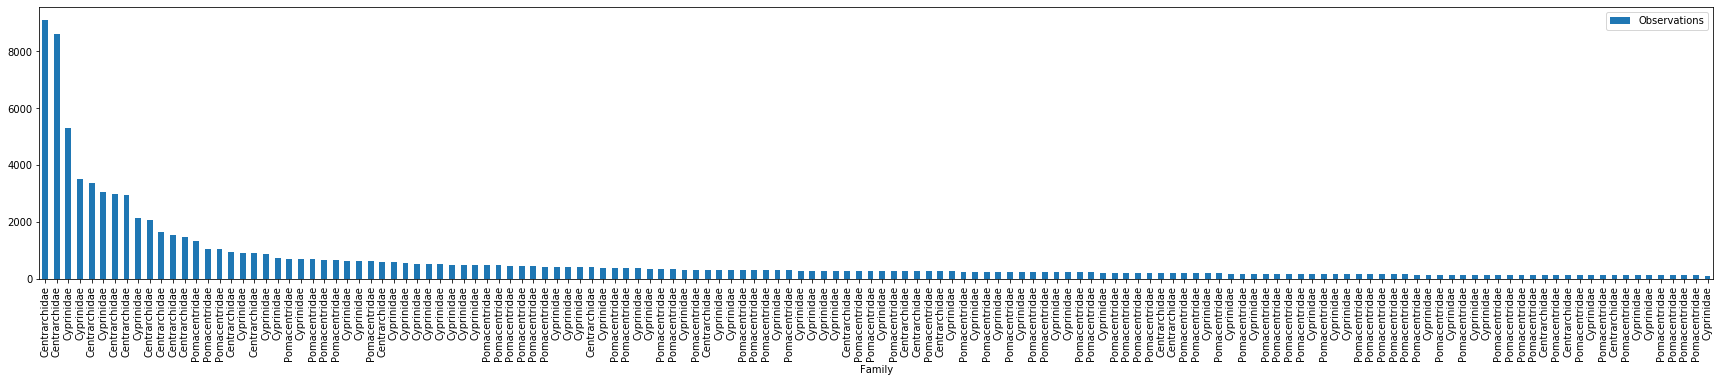

In [16]:
df_selected.plot(x='Family', y='Observations', kind='bar', figsize=(30,5))

In [17]:
df_selected.describe(include = 'object')

,Order,Family,Subfamily,Genus,Specie,url
count,144,144,121,144,144,144
unique,2,3,11,56,144,144
top,Perciformes,Pomacentridae,Pomacentrinae,Lepomis,Acanthochromis polyacanthus,https://www.inaturalist.org/taxa/57339-Chrysip...
freq,90,67,57,12,1,1


In [18]:
def count_nulls(df, column):
    return df[column].isnull().sum()

In [19]:
print(f"Order contains {count_nulls(df_selected, 'Order')} nan values.")
print(f"Family contains {count_nulls(df_selected, 'Family')} nan values.")
print(f"Subfamily contains {count_nulls(df_selected, 'Subfamily')} nan values.")
print(f"Genus contains {count_nulls(df_selected, 'Genus')} nan values.")
print(f"Specie contains {count_nulls(df_selected, 'Specie')} nan values.")

Order contains 0 nan values.
Family contains 0 nan values.
Subfamily contains 23 nan values.
Genus contains 0 nan values.
Specie contains 0 nan values.


In [20]:
df_nan_selected = df_selected[df_selected['Subfamily'].isnull()]
df_nan_selected

,Order,Family,Subfamily,Genus,Specie,Observations,url
13670,Perciformes,Centrarchidae,NaN,Lepomis,Lepomis macrochirus,9119,https://www.inaturalist.org/taxa/49591-Lepomis...
13688,Perciformes,Centrarchidae,NaN,Micropterus,Micropterus salmoides,8615,https://www.inaturalist.org/taxa/49587-Micropt...
13666,Perciformes,Centrarchidae,NaN,Lepomis,Lepomis cyanellus,3375,https://www.inaturalist.org/taxa/58636-Lepomis...
13667,Perciformes,Centrarchidae,NaN,Lepomis,Lepomis gibbosus,2969,https://www.inaturalist.org/taxa/49614-Lepomis...
13682,Perciformes,Centrarchidae,NaN,Micropterus,Micropterus dolomieu,2933,https://www.inaturalist.org/taxa/49590-Micropt...
13672,Perciformes,Centrarchidae,NaN,Lepomis,Lepomis megalotis,2045,https://www.inaturalist.org/taxa/58635-Lepomis...
13665,Perciformes,Centrarchidae,NaN,Lepomis,Lepomis auritus,1628,https://www.inaturalist.org/taxa/85365-Lepomis...
13693,Perciformes,Centrarchidae,NaN,Pomoxis,Pomoxis nigromaculatus,1521,https://www.inaturalist.org/taxa/49594-Pomoxis...
13659,Perciformes,Centrarchidae,NaN,Ambloplites,Ambloplites rupestris,1475,https://www.inaturalist.org/taxa/58637-Amblopl...
13668,Perciformes,Centrarchidae,NaN,Lepomis,Lepomis gulosus,922,https://www.inaturalist.org/taxa/104252-Lepomi...


In [21]:
df_selected.to_csv(CSV_PATH, index=False)

In [22]:
df_1000.to_csv(ALL_CSV_PATH, index=False)